# Banana Ripeness Detection - APS360

In [ ]:

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
from torchvision.models import alexnet, resnet50, ResNet50_Weights

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path




def plot_training_curve(train_loss, val_loss):
    """ Plots the training curve for a model run """

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training Curve for Best model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def get_accuracy(model, feature_loader):
    correct = 0
    total = 0
    model.eval()  # Add evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        for features, labels in feature_loader:  # Use feature loader
            outputs = model(features)
            pred = outputs.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.size(0)
    return correct / total

def evaluate(net, loader, criterion):
    total_loss = 0.0
    #total_err = 0.0
    total_epoch = 0
    net.eval()
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = labels.long()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        total_epoch += len(labels)
    loss = float(total_loss) / (i + 1)
    return loss


def train(model, train_feature_loader, valid_feature_loader, batch_size=30, learning_rate=0.01, num_epochs=30):
    torch.manual_seed(100)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    print("Training Started!\n")
    start_time = time.time()

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_epoch = 0

        # Training loop
        model.train()
        for i, data in enumerate(train_feature_loader):
            inputs, labels = data
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_epoch += len(labels)

        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(model, valid_feature_loader, criterion)



        train_acc[epoch] = get_accuracy(model, train_feature_loader)
        val_acc[epoch] = get_accuracy(model, valid_feature_loader)

        print(("Epoch {}: Train loss: {} Validation loss: {}").format( epoch + 1, train_loss[epoch], val_loss[epoch]))

        #print(f"Epoch {epoch+1}: Train acc: {train_acc[epoch]:.4f} | Val acc: {val_acc[epoch]:.4f}")
        print(f"Time elapsed: {time.time()-start_time:.2f}s")

    return np.arange(1, num_epochs+1), train_acc, val_acc, train_loss, val_loss




In [ ]:
class AlexNet_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'CNN_banana'
        self.conv1 = nn.Conv2d(256, 512, 3)
        self.pool = nn.MaxPool2d(2, 2)
        # was 0.25 for the 0.97 f1 score
        self.dropout_conv = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(512*2*2, 32)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 512*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Mount the drive (Contains the images of the different classes)
from google.colab import drive
drive.mount('/content/gdrive')
#nuz_path = '/content/gdrive/My Drive/Copy of APS360/banana_split_2'
#path_to_files = '/content/gdrive/My Drive/Copy of APS360/banana_split_2'

path_to_files = '/content/gdrive/MyDrive/APS360/banana_split_3'

Mounted at /content/gdrive


In [ ]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Training contains 80%, validation contains 10% and testing contains 10%
train_data = torchvision.datasets.ImageFolder(path_to_files + '/training/', transform=transform)
valid_data = torchvision.datasets.ImageFolder(path_to_files + '/validation/', transform=transform)
test_data = torchvision.datasets.ImageFolder(path_to_files + '/testing/', transform=transform)

batch_size = 1
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=1, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                           num_workers=1, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                           num_workers=1, shuffle=True)

classes = ['overripe', 'ripe', 'rotten', 'unripe']

In [ ]:
alex_net = alexnet(pretrained=True)
resnet_50 = resnet50(pretrained=True)


#Creating a new storage folder
new_folder_path = path_to_files + '/' + 'features'
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

count_train = 0
for img, label in train_loader:
    features = alex_net.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    training_folder = new_folder_path + '/training/' + str(classes[label])
    if not os.path.exists(training_folder):
        os.makedirs(training_folder)
    torch.save(features_tensor.squeeze(0), training_folder + '/' + str(count_train) + '.tensor')
    count_train += 1


#Validation Transfer Learning
count_val = 0
for img, label in valid_loader:
    features = alex_net.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    val_folder = new_folder_path + '/validation/' + str(classes[label])

    if not os.path.exists(val_folder):
        os.makedirs(val_folder)
    torch.save(features_tensor.squeeze(0), val_folder + '/' + str(count_val) + '.tensor')
    count_val += 1


#Testing Transfer Learning
count_test = 0
for img, label in test_loader:
    features = alex_net.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
    test_folder = new_folder_path + '/test/' + str(classes[label])
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    torch.save(features_tensor.squeeze(0), test_folder + '/' + str(count_test) + '.tensor')
    count_test += 1

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 135MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed

In [ ]:
# Extracting the features
new_folder_path = path_to_files + '/' + 'features'

train_features = torchvision.datasets.DatasetFolder(new_folder_path + '/training', loader=torch.load, extensions=('.tensor'))
valid_features = torchvision.datasets.DatasetFolder(new_folder_path + '/validation', loader=torch.load, extensions=('.tensor'))
test_features = torchvision.datasets.DatasetFolder(new_folder_path + '/test', loader=torch.load, extensions=('.tensor'))

train_feature_loader = torch.utils.data.DataLoader(train_features, batch_size=batch_size,
                                           num_workers=1, shuffle=True)
valid_feature_loader = torch.utils.data.DataLoader(valid_features, batch_size=batch_size,
                                           num_workers=1, shuffle=True)
test_feature_loader = torch.utils.data.DataLoader(test_features, batch_size=batch_size,
                                           num_workers=1, shuffle=True)

In [ ]:
'''model = AlexNet_CNN()
epochs, train_acc, val_acc, training_loss, val_loss = train(model, train_feature_loader, valid_feature_loader, batch_size=64, learning_rate=0.0001, num_epochs=30)

model2 = AlexNet_CNN()
epochs, train_acc, val_acc, training_loss2, val_loss2 = train(model2, train_feature_loader, valid_feature_loader, batch_size=32, learning_rate=0.0001, num_epochs=30)'''

model = AlexNet_CNN()
epochs, train_acc, val_acc, training_loss, val_loss = train(model, train_feature_loader, valid_feature_loader, batch_size=64, learning_rate=0.0001, num_epochs=30)


'''model2 = AlexNet_CNN()
epochs2, train_acc2, val_acc2, training_loss2, val_loss2 = train(model2, train_feature_loader, valid_feature_loader, batch_size=64, learning_rate=0.01, num_epochs=30)



model3 = AlexNet_CNN()
epochs3, train_acc3, val_acc3, training_loss3, val_loss3 = train(model3, train_feature_loader, valid_feature_loader, batch_size=64, learning_rate=0.001, num_epochs=10)
import matplotlib.pyplot as plt

# train loss plotting
plt.plot(epochs, training_loss)
plt.plot(epochs, val_loss)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# train loss plotting
plt.plot(epochs2, training_loss2)
plt.plot(epochs2, val_loss2)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(epochs3, training_loss3)
plt.plot(epochs3, val_loss3)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
'''
# validation plotting

'''
plt.plot(epochs, train_acc)
plt.title("Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")'''

Training Started!

Epoch 1: Train loss: 0.31570996950100727 Validation loss: 0.19206122081875865
Time elapsed: 303.62s
Epoch 2: Train loss: 0.06395461936830285 Validation loss: 0.36642588569375195
Time elapsed: 351.73s
Epoch 3: Train loss: 0.01954555509434076 Validation loss: 0.2787833815262946
Time elapsed: 402.16s
Epoch 4: Train loss: 0.002631817446469125 Validation loss: 0.2452182618318158
Time elapsed: 454.15s
Epoch 5: Train loss: 0.0005325340554362795 Validation loss: 0.24746408324222113
Time elapsed: 504.88s
Epoch 6: Train loss: 0.000214935955184185 Validation loss: 0.2597029856311565
Time elapsed: 556.74s
Epoch 7: Train loss: 0.00011461492242804906 Validation loss: 0.2731372430667072
Time elapsed: 612.22s
Epoch 8: Train loss: 6.272031853006528e-05 Validation loss: 0.30772147441057146
Time elapsed: 668.87s
Epoch 9: Train loss: 0.008382904300067459 Validation loss: 0.8507842312732865
Time elapsed: 718.86s
Epoch 10: Train loss: 0.07440474016278906 Validation loss: 0.316743728849056

'\nplt.plot(epochs, train_acc)\nplt.title("Training Curve")\nplt.xlabel("Epochs")\nplt.ylabel("Training Accuracy")\nplt.show()\n\nplt.plot(epochs, val_acc)\nplt.title("Validation Curve")\nplt.xlabel("Epochs")\nplt.ylabel("Validation Accuracy")'

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Get predictions
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_feature_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


for i in range(len(y_true)):
    y_true[i] = classes[y_true[i]]
    y_pred[i] = classes[y_pred[i]]

    print(f"True label: {y_true[i]}, Predicted label: {y_pred[i]}")
    print()


print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

model_path = get_model_name(model.name, 64, 0.0001, 29)
torch.save(model.state_dict(), model_path)

True label: rotten, Predicted label: rotten

True label: ripe, Predicted label: ripe

True label: overripe, Predicted label: ripe

True label: rotten, Predicted label: rotten

True label: unripe, Predicted label: unripe

True label: ripe, Predicted label: ripe

True label: ripe, Predicted label: ripe

True label: unripe, Predicted label: unripe

True label: ripe, Predicted label: ripe

True label: unripe, Predicted label: unripe

True label: overripe, Predicted label: overripe

True label: rotten, Predicted label: rotten

True label: rotten, Predicted label: rotten

True label: rotten, Predicted label: ripe

True label: ripe, Predicted label: ripe

True label: overripe, Predicted label: overripe

True label: ripe, Predicted label: ripe

True label: overripe, Predicted label: overripe

True label: ripe, Predicted label: ripe

True label: unripe, Predicted label: unripe

True label: unripe, Predicted label: unripe

True label: ripe, Predicted label: ripe

True label: rotten, Predicted la

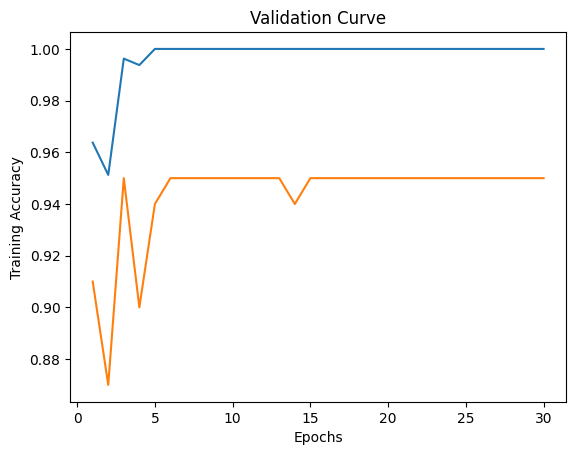

In [ ]:

import matplotlib.pyplot as plt
plt.plot(epochs, train_acc)
plt.title("Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")

plt.plot(epochs, val_acc)
plt.title("Validation Curve")
plt.xlabel("Epochs")
plt.show()

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

def predict_single_image(image_path, model, alex_net, classes):
    model.eval()
    alex_net.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0)

    # Feature extraction with AlexNet
    with torch.no_grad():
        features = alex_net.features(input_tensor)

    # Prediction with your CNN
    with torch.no_grad():
        outputs = model(features)

    # Get predicted class
    _, predicted = torch.max(outputs, 1)
    return classes[predicted.item()]

model = AlexNet_CNN()
model.load_state_dict(torch.load('best_model.pth'))


image_path = '/content/gdrive/MyDrive/APS360/banana_test/IMG_8456.jpeg'
prediction = predict_single_image(image_path, model, alex_net, classes)
print(f"Predicted class: {prediction}")

true_label = 'overripe'
print(f"Actual class: {true_label}")
print(f"Correct: {prediction == true_label}")

In [ ]:
torch.save(model.state_dict(), 'best_model.pth')